In [115]:
import numpy as np
import pandas as pd
from tinkoff.invest import Client
from tinkoff.invest.utils import now
from datetime import timedelta

In [5]:
TOKEN0 = 't.UFRJ8SC9hafVOhFxEUY7yf1wZ1gGhwJp-WCp9o4rnEChHWns0c3jQ21eQwoOW_RurFqeZpss2scJkmMQnomJ9g'
TOKEN1 = 't.6nHltT1dYSfrVTIV9zF72fxDlB2sXJbRD6iJNpZXTFAN61rmD7m71xPp9ko12ta1JxA06em4YdN36xicnBmjWg'

token = TOKEN0

res = []
with Client(token) as client:
    accounts = client.users.get_accounts()

In [17]:
import logging
import os
from datetime import timedelta
from pathlib import Path

from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.caching.market_data_cache.cache import MarketDataCache
from tinkoff.invest.caching.market_data_cache.cache_settings import (
    MarketDataCacheSettings,
)
from tinkoff.invest.utils import now


In [18]:
def get_candles(figi, interval, days = 180):
    res = []
    with Client(token) as client:
        settings = MarketDataCacheSettings(base_cache_dir=Path("market_data_cache_01"))
        market_data_cache = MarketDataCache(settings=settings, services=client)
        for candle in market_data_cache.get_all_candles(
            figi = figi,
            from_=now() - timedelta(days=days),
            interval= interval,
        ):
            price_row = [candle.open,  candle.high, candle.low, candle.close]
            price_row = [money_value(x) for x in price_row]
            res.append([candle.time] + price_row)    
        return res       
    
def get_open_price(candles):
    res = []
    for row in candles:
        sdate = row[0]
        sdate = sdate.strftime("%Y-%m-%d")
        res.append([sdate] + row[1:2]) 
    df = pd.DataFrame(res, columns = ['date', 'ticker'])
    df = df.set_index('date')
    
    return df

def get_id_base(TOKEN):
    with Client(TOKEN) as cl:
        instruments = cl.instruments
        market_data = cl.market_data
    
        l = []
        for method in ['shares', 'currencies', 'futures', 'bonds', 'etfs']:
            for item in getattr(instruments, method)().instruments:
                l.append({
                    'ticker': item.ticker,
                    'figi': item.figi,
                    'type': method,
                    'name': item.name,
                    'cur' : item.currency,
                    'lot' : item.lot
                })
    
        df = pd.DataFrame(l)
    return df

def ticker_to_figi(ticker, df):
    dfx = df[df['ticker'] == ticker]   
    if dfx.shape[0] > 0 :
        figi = dfx['figi'].iloc[0]
        return figi
    else:
        return None

def figi_to_ticker(figi, df):
    dfx = df[df['figi'] == figi]   
 
    if dfx.shape[0] > 0 :
        ticker = dfx['ticker'].iloc[0]      
        return ticker
    else :
        return None

def figi_to_name(figi, df):
    dfx = df[df['figi'] == figi]   
 
    if dfx.shape[0] > 0 :
        res = dfx['name'].iloc[0]      
        return res
    else :
        return None
    
    
def money_value(price):
    return price.units + price.nano / 1e9

In [19]:
base = get_id_base(token)

In [20]:
dfx = base[base["type"] == "shares"]
dfx = dfx[dfx["cur"] == "rub"]

In [21]:
res = []
for row in dfx.iterrows():
    pos = row[1]
#    print(pos.figi)        
    candles = get_candles(pos.figi, CandleInterval.CANDLE_INTERVAL_DAY, 500)
    df =  get_open_price(candles)
    ticker = figi_to_ticker(pos.figi, base)
    
    if ticker == None:
        ticker = pos.figi
    df.columns = [ticker]
    res.append(df)
    
dfp = pd.concat(res, axis = 1)


### PyBroker format

In [41]:
def get_ohlc(candles):
    res = []
    for row in candles:
        sdate = row[0]
        sdate = sdate.strftime("%Y-%m-%d")
        res.append([sdate] + row[1:5]) 
    df = pd.DataFrame(res, columns = ['date', 'open', 'high', 'low', 'close'])
    
    return df

In [42]:
dfx = base[base["type"] == "shares"]
dfx = dfx[dfx["cur"] == "rub"]

res = []
for row in dfx.iterrows():
    pos = row[1]
#    print(pos.figi)        
    candles = get_candles(pos.figi, CandleInterval.CANDLE_INTERVAL_DAY, 500)
    df =  get_ohlc(candles)
    ticker = figi_to_ticker(pos.figi, base)
    if ticker == None:
        ticker = pos.figi
    df['symbol'] = ticker
    res.append(df)

In [46]:
dfp = pd.concat(res, axis = 0)
dfp.to_csv("prices.csv", index = False)

,date,open,high,low,close,symbol
0,2022-10-25,72.98,74.30,70.08,73.52,DSKY
1,2022-10-26,74.36,74.40,72.04,74.32,DSKY
2,2022-10-27,74.44,74.76,73.44,74.30,DSKY
3,2022-10-28,73.98,74.50,72.74,74.14,DSKY
4,2022-10-31,74.46,75.00,74.04,74.80,DSKY
...,...,...,...,...,...,...
343,2024-03-01,1652.00,1678.80,1639.00,1671.20,CHMF
344,2024-03-04,1674.60,1682.20,1661.60,1670.80,CHMF
345,2024-03-05,1674.20,1688.80,1663.40,1679.20,CHMF
346,2024-03-06,1685.80,1688.80,1678.20,1685.40,CHMF


In [47]:
import pandas as pd
import pybroker
from pybroker.data import DataSource

class CSVDataSource(DataSource):

    def __init__(self):
        super().__init__()
        # Register custom columns in the CSV.
        pybroker.register_columns('rsi')

    def _fetch_data(self, symbols, start_date, end_date, _timeframe, _adjust):
        df = pd.read_csv('prices.csv')
        df = df[df['symbol'].isin(symbols)]
        df['date'] = pd.to_datetime(df['date'])
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [51]:
csv_data_source = CSVDataSource()
df = csv_data_source.query(['DSKY'], '6/1/2023', '12/1/2024')
df

Loading bar data...
Loaded bar data: 0:00:00 



,date,open,high,low,close,symbol
0,2023-06-01,70.46,71.26,70.38,71.22,DSKY
1,2023-06-02,71.22,71.34,70.84,71.16,DSKY
2,2023-06-05,71.04,71.36,71.04,71.20,DSKY
3,2023-06-06,71.12,71.30,71.12,71.28,DSKY
4,2023-06-07,71.18,71.34,71.18,71.30,DSKY
...,...,...,...,...,...,...
192,2024-03-01,51.46,52.60,50.50,51.08,DSKY
193,2024-03-04,51.00,52.34,49.80,50.06,DSKY
194,2024-03-05,50.06,50.16,48.62,48.90,DSKY
195,2024-03-06,48.92,49.22,48.00,48.62,DSKY


### Rebalance Equal Position Sizing

In [75]:
import pybroker as pyb
from datetime import datetime
from pybroker import ExecContext, Strategy, StrategyConfig, FeeMode

pyb.enable_data_source_cache('rebalancing')

In [99]:
d = now()
d.weekday()

4

In [101]:
 pyb.param('current_month')

<function pybroker.scope.param(name: str, value: Optional[Any] = <object object at 0x0000027800592840>) -> Optional[Any]>

In [103]:
def start_of_month(dt: datetime) -> bool:
    if dt.month != pyb.param('current_month'):
        pyb.param('current_month', dt.month)
        return True
    return False

def start_of_week(dt: datetime) -> bool:
    if dt.weekday() == 0:
        return True
    return False

In [56]:
def set_target_shares(
    ctxs: dict[str, ExecContext],
    targets: dict[str, float]
):
    for symbol, target in targets.items():
        ctx = ctxs[symbol]
        target_shares = ctx.calc_target_shares(target)
        pos = ctx.long_pos()
        if pos is None:
            ctx.buy_shares = target_shares
        elif pos.shares < target_shares:
            ctx.buy_shares = target_shares - pos.shares
        elif pos.shares > target_shares:
            ctx.sell_shares = pos.shares - target_shares

In [104]:
def rebalance(ctxs: dict[str, ExecContext]):
    dt = tuple(ctxs.values())[0].dt
    if start_of_week(dt):
        target = 1 / len(ctxs)
        set_target_shares(ctxs, {symbol: target for symbol in ctxs.keys()})

In [105]:
fee = FeeMode('order_percent')
config = StrategyConfig(fee_mode = fee, fee_amount = 0.05)

In [106]:
strategy = Strategy(csv_data_source, start_date='1/1/2023', end_date='7/3/2024', config = config)
strategy.add_execution(None, ['DSKY', 'CHMF'])
strategy.set_after_exec(rebalance)
result = strategy.backtest()

Backtesting: 2023-01-01 00:00:00 to 2024-07-03 00:00:00

Loaded cached bar data.

Test split: 2023-01-03 00:00:00 to 2024-03-07 00:00:00


100% (300 of 300) |######################| Elapsed Time: 0:00:00 Time:  0:00:000:00



Finished backtest: 0:00:00


In [107]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,CHMF,2023-01-10,57,NaN,866.00,24.68
2,buy,DSKY,2023-01-10,725,NaN,68.67,24.89
3,sell,CHMF,2023-01-17,2,NaN,914.90,0.91
4,buy,DSKY,2023-01-17,25,NaN,68.59,0.86
5,sell,DSKY,2023-01-24,6,NaN,67.83,0.20
...,...,...,...,...,...,...,...
85,buy,DSKY,2024-02-20,16,NaN,57.10,0.46
86,sell,CHMF,2024-02-27,1,NaN,1621.60,0.81
87,buy,DSKY,2024-02-27,33,NaN,53.77,0.89


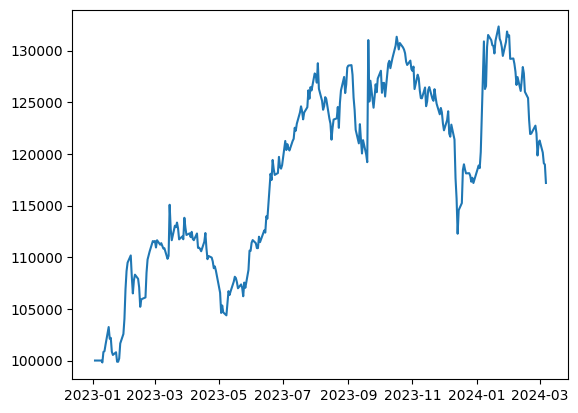

In [108]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

In [109]:
result.positions

,,long_shares,short_shares,close,equity,market_value,margin,unrealized_pnl
symbol,date,,,,,,,
CHMF,2023-01-10,57,0,863.60,49225.20,49225.20,0.0,-136.80
DSKY,2023-01-10,725,0,68.60,49735.00,49735.00,0.0,-50.75
CHMF,2023-01-11,57,0,879.80,50148.60,50148.60,0.0,786.60
DSKY,2023-01-11,725,0,68.74,49836.50,49836.50,0.0,50.75
CHMF,2023-01-12,57,0,880.40,50182.80,50182.80,0.0,820.80
...,...,...,...,...,...,...,...,...
DSKY,2024-03-05,1199,0,48.90,58631.10,58631.10,0.0,-20743.68
CHMF,2024-03-06,35,0,1685.40,58989.00,58989.00,0.0,24360.10
DSKY,2024-03-06,1199,0,48.62,58295.38,58295.38,0.0,-21079.40


In [64]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop
id,,,,,,,,,,,,,
1,long,CHMF,2023-01-04,2023-02-02,891.9,987.50,2,191.20,10.72,191.20,21,9.10,None
2,long,CHMF,2023-01-04,2023-03-02,891.9,1052.00,2,320.20,17.95,511.40,40,8.01,None
3,long,DSKY,2023-01-04,2023-04-04,69.2,72.33,10,31.30,4.52,542.70,62,0.50,None
4,long,DSKY,2023-01-04,2023-05-03,69.2,67.94,20,-25.20,-1.82,517.50,82,-0.31,None
5,long,CHMF,2023-01-04,2023-06-02,891.9,1032.80,1,140.90,15.80,658.40,103,1.37,None
6,long,CHMF,2023-01-04,2023-07-04,891.9,1213.00,4,1284.40,36.00,1942.80,124,10.36,None
7,long,CHMF,2023-01-04,2023-08-02,891.9,1363.00,3,1413.30,52.82,3356.10,145,9.75,None
8,long,CHMF,2023-01-04,2023-09-04,891.9,1433.90,1,542.00,60.77,3898.10,168,3.23,None
9,long,DSKY,2023-01-04,2023-10-03,69.2,69.50,22,6.60,0.43,3904.70,189,0.03,None


In [92]:
result.metrics_df

,name,value
0,trade_count,14.000000
1,initial_market_value,100000.000000
2,end_market_value,116073.930000
3,total_pnl,11824.850000
4,unrealized_pnl,4249.080000
5,total_return_pct,11.824850
6,total_profit,11850.050000
7,total_loss,-25.200000
8,total_fees,90.010000
9,max_drawdown,-18810.370000


### Portfolio Optimization

In [116]:
import pandas as pd
import riskfolio as rp

pyb.param('lookback', 90)  # Use past year of returns.

def calculate_returns(ctxs: dict[str, ExecContext], lookback: int):
    prices = {}
    for ctx in ctxs.values():
        prices[ctx.symbol] = ctx.close[-lookback:]
    df = pd.DataFrame(prices)
    return df.pct_change().dropna()

def optimization(ctxs: dict[str, ExecContext]):
    lookback = pyb.param('lookback')
    first_ctx = tuple(ctxs.values())[0]
    if start_of_week(first_ctx.dt):
        Y = calculate_returns(ctxs, lookback)
        port = rp.Portfolio(returns=Y)
        port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
        w = port.optimization(
            model='Classic',
            rm='CVaR',
            obj='MinRisk',
            rf=0,      # Risk free rate.
            l=0,       # Risk aversion factor.
            hist=True  # Use historical scenarios.
        )
        targets = {
            symbol: w.T[symbol].values[0]
            for symbol in ctxs.keys()
        }
        set_target_shares(ctxs, targets)

In [117]:
strategy.set_after_exec(optimization)
result = strategy.backtest(warmup=pyb.param('lookback'))

Backtesting: 2023-01-01 00:00:00 to 2024-07-03 00:00:00

Loaded cached bar data.

Test split: 2023-01-03 00:00:00 to 2024-03-07 00:00:00


100% (300 of 300) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000



Finished backtest: 0:00:01


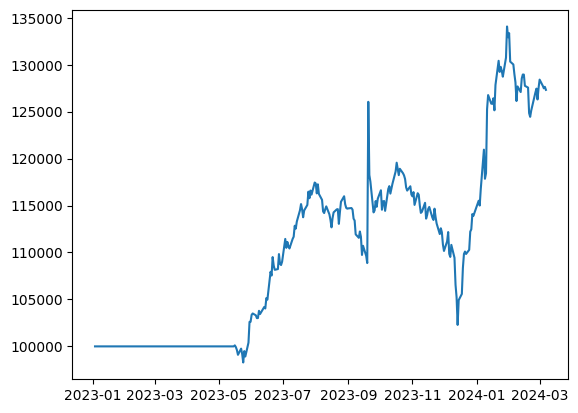

In [118]:
chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])